In [1]:
import os

import pandas as pd
import numpy as np

import urllib
from urllib.request import urlopen
import json
import requests

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from fbprophet import Prophet

In [2]:
def get_apple_link():
    """Get link of Apple Mobility Trends report file
    Output:
        data_link (str): link of Apple Mobility Trends report file
        data_name (str): name of Apple Mobility Trends report file
    """
    # get link via API
    link = "https://covid19-static.cdn-apple.com/covid19-mobility-data/current/v3/index.json"
    with urlopen(link) as url:
        json_data = json.loads(url.read().decode())
        pass
    # get link components from json dictionary
    basePath = json_data["basePath"]
    csvPath = json_data["regions"]["en-us"]["csvPath"]
    # aggregate to produce file link
    file_link = ("https://covid19-static.cdn-apple.com" + basePath + csvPath)
    # get file name
    file_name = file_link.rsplit('/', 1)[-1]
    
    return file_link, file_name

def save_file(data_directory = 'data'):
    """Check for updates and download the Trends report
    Input:
        data_directory (str): directory for saving the data
    Output:
        new_file_path (str): file path of most recently downloaded data
    """
    # create a data directory if it does not already exist
    directory = data_directory
    if not os.path.exists(directory):
        os.mkdir(directory)
        pass
    
    # get new file link and file name
    data_link, data_name = get_apple_link()
    
    # remove eveything in the data directory
    all_files = os.listdir(directory)
    [os.remove(os.path.join(directory, f)) for f in all_files]
    # save new data into the data directory
    new_file_path = os.path.join(directory, data_name)
    urllib.request.urlretrieve(data_link, new_file_path)
    
    return new_file_path

def clean_data(trends):
    """Clean data to desired format
    Input:
        trends (dataframe): original Apple Mobility Trends report as a dataframe
    Output:
        trends (dataframe): double indexed by 'country' and 'transportation type'
                            columns are dates
        country_names (list): a list of all country names in the Trends report
    """
    # filter by country level data
    trends = trends[trends['geo_type'] == 'country/region']
    # drop unused columns and change column name
    trends = trends.drop(['geo_type', 'alternative_name', 'sub-region', 'country'], axis = 1)
    trends = trends.rename({'region': 'country'}, axis = 1)
    # get country names
    country_names = trends['country'].unique()
    # set hierarchical index
    trends.set_index(['country', 'transportation_type'], inplace = True)
    
    return trends, country_names

def get_country_trend(trends_countries, country_names, country_name = 'United States'):
    """filter trends by user-defined country
    Input:
        trends (dataframe): double indexed by 'country' and 'transportation type'
                            columns are dates
        country_names (list): a list of all country names in the Trends report
        country_name (string): user defined country name
    Output:
        trends_country (dataframe): trends for user-specified country
                                    indexed by date
                                    columns are transportation type
    """
    # check if country exists
    # return corresponding data if yet
    if country_name in country_names:
        trends_country = trends_countries.loc[country_name].transpose()
        
        return trends_country
    # return US data if not
    else:
        print('No Data available for ' + country_name + '.')
        trends_country = trends_countries.loc['United States'].transpose()
        
        return trends_country
    
def forecast_trend(country_trend, periods = 30):
    """forecast mobility trend for user-defined period of time for a country 
    Input: 
        country_trend (dataframe): trends for user-specified country
                                   indexed by date
                                   columns are transportation type
        periods (int): projection period; defaulted at 30
    Output:
        forecast_df (dataframe): forecasted trend for country in country_trend
                                 indexed by date
                                 columns are transportation type
    """
    # get transportation types
    t_types = country_trend.columns
    # set up an empty dataframe for storing forecasting result
    forecast_df = pd.DataFrame(columns = ['date'])
    # loop through a transportation type and perform forecasting individually
    for t_type in t_types:
        # prep dataframe so it can be interpreted by Prophet
        t_type_trend = country_trend[[t_type]].reset_index()
        t_type_trend = t_type_trend.rename(columns = {'index':'ds', t_type:'y'})
        # instantiate a Prophet object and define prediction specs
        m = Prophet(yearly_seasonality= False, daily_seasonality= False)
        m.fit(t_type_trend)
        future = m.make_future_dataframe(periods=periods, include_history = False)
        # make prediction
        forecast = m.predict(future)
        forecast = forecast[['ds', 'yhat']]
        # change column names
        forecast = forecast.rename(columns = {'ds':'date', 'yhat':t_type})
        # marge dataframe so it follows the same form as the input dataframe
        forecast_df = pd.merge(forecast_df, forecast, how = 'outer', left_on = 'date', right_on = 'date')
        pass
    # use date as index
    forecast_df = forecast_df.set_index('date')
    
    return forecast_df

In [3]:
# download and save file
data_loc = save_file()
# read file
trends = pd.read_csv(data_loc, parse_dates = True, low_memory = False)
# clean data and get country names
trends_countries, country_names = clean_data(trends)
# print country names
print(country_names)

['Albania' 'Argentina' 'Australia' 'Austria' 'Belgium' 'Brazil' 'Bulgaria'
 'Cambodia' 'Canada' 'Chile' 'Colombia' 'Croatia' 'Czech Republic'
 'Denmark' 'Egypt' 'Estonia' 'Finland' 'France' 'Germany' 'Greece'
 'Hong Kong' 'Hungary' 'Iceland' 'India' 'Indonesia' 'Ireland' 'Israel'
 'Italy' 'Japan' 'Latvia' 'Lithuania' 'Luxembourg' 'Macao' 'Malaysia'
 'Mexico' 'Morocco' 'Netherlands' 'New Zealand' 'Norway' 'Philippines'
 'Poland' 'Portugal' 'Republic of Korea' 'Romania' 'Russia' 'Saudi Arabia'
 'Serbia' 'Singapore' 'Slovakia' 'Slovenia' 'South Africa' 'Spain'
 'Sweden' 'Switzerland' 'Taiwan' 'Thailand' 'Turkey' 'Ukraine'
 'United Arab Emirates' 'United Kingdom' 'United States' 'Uruguay'
 'Vietnam']


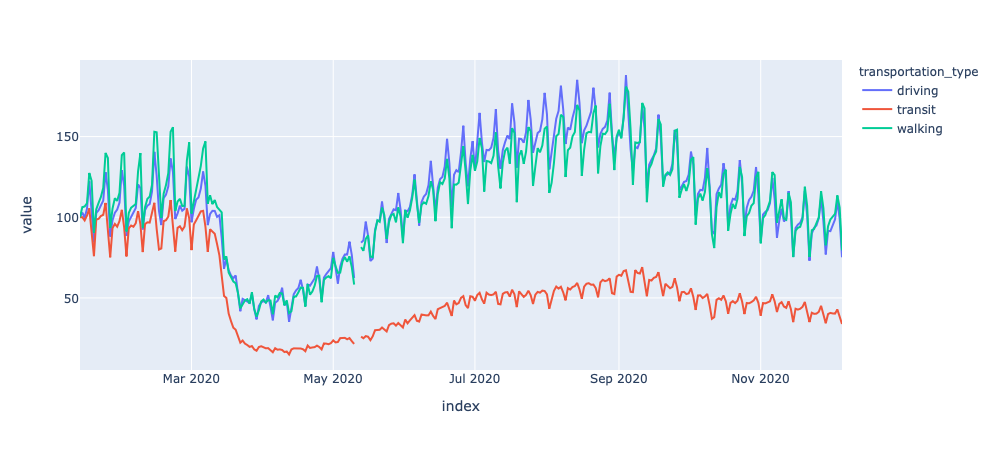

In [4]:
# get trends for Canada
trends_canada = get_country_trend(trends_countries, country_names, country_name = 'Canada')
# visualize data
px.line(trends_canada)

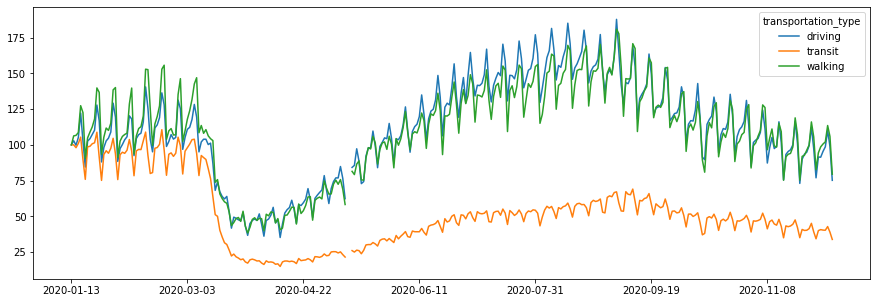

In [5]:
# visualize with matplotlib because plotly doesnt show on GitHub
trends_canada.plot(figsize = (15, 5))

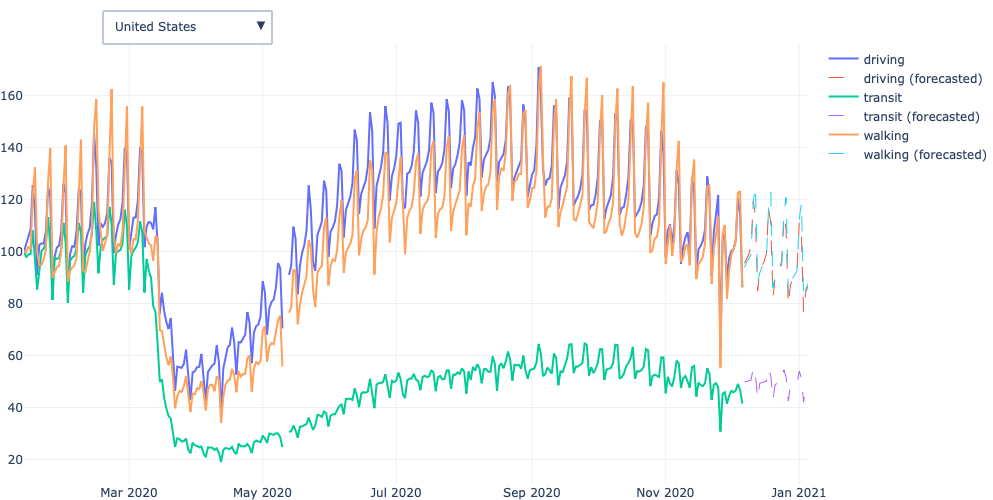

In [6]:
# define default country
default_country = 'United States'
# define lists fort keeping track of added plots and buttons
add_country_plots = []
buttons = []

# create figure
fig = go.Figure()

# add scatter trace for each transportation type and for each country
# loop through country, get corresponding dataframe and projection for each transportation type
for country in country_names:
    # get historical trend
    country_trend = get_country_trend(trends_countries, country_names, country_name = country)    
    # get forecast
    country_forecast = forecast_trend(country_trend)
    
    # loop through each available transportation type in a country
    for transportation in country_trend.columns:
        # add trace of historical trends
        fig.add_trace(go.Scatter(x =country_trend.index, 
                                 y = country_trend[transportation], 
                                 mode = 'lines', 
                                 name = transportation,
                                 visible = (country == default_country))) # keep default visible only
        # update lists
        add_country_plots.append(country)
        # add trace of forecasted trends
        fig.add_trace(go.Scatter(x = country_forecast.index,
                                 y = country_forecast[transportation],
                                 line=dict(width=1, dash='longdash'),
                                 name = transportation + ' (forecasted)',
                                 visible = (country == default_country))) # keep default visible only
        # update lists
        add_country_plots.append(country)

# Update plot sizing
fig.update_layout(
    width=1200,
    height=500,
    autosize=False,
    margin=dict(t=0, b=0, l=0, r=1),
    template="plotly_white",
)

# add button for each country
# loop through country and configure button
# button visibility controls for what trace to appear, correspond to add_country_plots
for country in country_names:
    buttons.append(dict(method='update',
                        label=country,
                        args = [{'visible': [country == c for c in add_country_plots]}]))

# Add dropdown
fig.update_layout(
    updatemenus=[
        dict(
            buttons = buttons,
            direction = "down",
            pad = {"r": 10, "t": 10},
            showactive = True,
            active = list(country_names).index(default_country),
            x = 0.1,
            xanchor = "left",
            y = 1.1,
            yanchor = "top"
        ),
    ]
)


fig.show()